# 1 Import necessary libraries

In [1]:
import earthaccess # needed to discover and download TEMPO data
import netCDF4 as nc # needed to read TEMPO data

import os
import sys

import platform
from subprocess import Popen
import shutil

import numpy as np

import matplotlib.pyplot as plt # needed to plot the resulting time series
from matplotlib.pyplot import cm
from datetime import datetime, timedelta # needed to work with time in plotting time series

import getpass
import traceback
from typing import Dict

import cmr
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# 2 Define functions

## 2.1 function to read TEMPO_NO2_L2_V03 subsets created by Harmony

In [2]:
def read_TEMPO_NO2_subset(fname):

  try:
    ds = nc.Dataset(fn)

    geo = ds.groups['geolocation']
    var = geo.variables['time'] # this reads variable column_amount_o3 from prod (group product, /product)
    time = np.array(var)

    var = geo.variables['latitude'] # this reads variable column_amount_o3 from prod (group product, /product)
    lat = np.array(var)
    fv_lat = var.getncattr('_FillValue')

    var = geo.variables['longitude'] # this reads variable column_amount_o3 from prod (group product, /product)
    lon = np.array(var)
    fv_lon = var.getncattr('_FillValue')

    prod = ds.groups['product'] # this opens group product, /product, as prod
    var = prod.variables['vertical_column_troposphere'] # this reads variable vertical_column from prod (group product, /product)
    NO2_trop_col = np.array(var)
    fv_NO2_trop_col = var.getncattr('_FillValue')

    var_unc = prod.variables['vertical_column_troposphere_uncertainty'] # this reads variable vertical_column_uncertainty from prod (group product, /product)
    NO2_trop_col_unc = np.array(var_unc)
    fv_NO2_trop_col_unc = var.getncattr('_FillValue')

    var_QF = prod.variables['main_data_quality_flag'] # this reads variable main_data_quality_flag from prod (group product, /product)
    NO2_trop_col_QF = np.array(var_QF)
    fv_QF = var_QF.getncattr('_FillValue')

    ds.close()

  except:
    time = 0.
    lat = 0.
    fv_lat = 0.
    lon = 0.
    fv_lon = 0.
    NO2_trop_col = 0.
    fv_NO2_trop_col = 0.
    NO2_trop_col_unc = 0.
    fv_NO2_trop_col_unc = 0.
    NO2_trop_col_QF = 0.
    fv_QF = 0.

  return time, lat, fv_lat, lon, fv_lon\
, NO2_trop_col, fv_NO2_trop_col\
, NO2_trop_col_unc, fv_NO2_trop_col_unc\
, NO2_trop_col_QF, fv_QF

## 2.2 function computing geolocations of a regular grid

In [3]:
def grid(dlat, dlon, nlat, nlon):
# function grid_count creates a grid defined by the steps dlat, dlon in latitudinal and longitudinal directions
# and the number of gridboxes in these directions, nlat and nlon
# the southmost latitude, lat0 = 17.0, and westmost longitude, lon0 = -155.0, are fixed
# if the opposite sides of the domain is more than one step away from the original TEMPO L3 V01 margins of the array, a warning is printed.
# Parameters of  the original TEMPO L3 V01 are given below:
# lat0 = 17.0 # southmost latitude;
# latlast = 17 + 940*0.05 = 64 # northmost latitude;
# dlat = 0.05 # latitudinal grid step;
# lon0 = -155.0 # westmost longitude;
# lonlast = -155.0 + 2611*0.05 = -24.45 # eastmost longitude; 
# dlon = 0.05 # longitudinal grid step
# nx = 2611
# ny = 940
    lat0 = 17.0 # southmost latitude
    lon0 = -155.0 # westmost longitude
    latlast = 64 # northmost latitude;
    lonlast = -24.45 # eastmost longitude;
    if abs(lat0+dlat*nlat - latlast) > dlat:
        print('the eastmost longitude (',lat0+dlat*nlat,') is more than one gridbox (',dlat,') away from TEMPO L3 V01 domain margin')
    if abs(lon0+dlon*nlon - lonlast) > dlon:
        print('the eastmost longitude (',lon0+dlon*nlon,') is more than one gridbox (',dlon,') away from TEMPO L3 V01 domain margin')
    grid_lat = np.linspace(lat0+dlat*0.5, lat0+dlat*(nlat-0.5), nlat, endpoint=True, dtype=float)
    grid_lon = np.linspace(lon0+dlon*0.5, lon0+dlon*(nlon-0.5), nlon, endpoint=True, dtype=float)

    return grid_lat, grid_lon

# 2.3 function counting occasions of geoloacted observations in the gridboxes

In [4]:
def grid_count(grid_lat, grid_lon, lat, lon):
# function grid_count takes a grid defined by  centers of gridboxes
# restores grid parameters dlat, dlon nlat, nlon lat0, lon0
#
# below are parameters of TEMPO L3 V01 grid
# the southmost latitude, lat0 = 17.0, and westmost longitude, lon0 = -155.0, are fixed
# Parameters of  the original TEMPO L3 V01 are given below:
# lat0 = 17.0 # southmost latitude;
# latlast = 17 + 940*0.05 = 64 # northmost latitude;
# dlat = 0.05 # latitudinal grid step;
# lon0 = -155.0 # westmost longitude;
# lonlast = -155.0 + 2611*0.05 = -24.45 # eastmost longitude; 
# dlon = 0.05 # longitudinal grid step
# nlon = 2611
# nlat = 940
# if the opposite sides of the domain is more than one step away from the original TEMPO L3 V01 margins of the array, a warning is printed.

    nlat = len(grid_lat)
    dlat = (grid_lat[-1] - grid_lat[0])/(nlat-1)
    lat0 = grid_lat[0] - dlat*0.5 # southmost latitude

    nlon = len(grid_lon)
    dlon = (grid_lon[-1] - grid_lon[0])/(nlon-1)
    lon0 = grid_lon[0] - dlon*0.5 # westmost longitude

# block below can be removed. It warns user if domain is way different from TEMPO L3 V01 grid
    latlast = 64 # northmost latitude of TEMPO L3 V01 grid;
    lonlast = -24.45 # eastmost longitude of TEMPO L3 V01 grid;
    if abs(lat0+dlat*nlat - latlast) > dlat:
        print('the eastmost longitude (',lat0+dlat*nlat,') is more than one gridbox (',dlat,') away from TEMPO L3 V01 domain margin')
    if abs(lon0+dlon*nlon - lonlast) > dlon:
        print('the eastmost longitude (',lon0+dlon*nlon,') is more than one gridbox (',dlon,') away from TEMPO L3 V01 domain margin')

# counts number of occurences of positions on 0.05 degree grid defined by parameters lat0, dlat, ny, lon0, dlon, nx
    count = np.empty([nlat, nlon], dtype=int)
    count[:,:] = 0
    for latc, lonc in zip(lat, lon):
# lat lon griboxes are calculated as index = int((x - x0)/dx)
        i = int((latc - lat0)/dlat)
        j = int((lonc - lon0)/dlon)
        if i < 0 or i > nlat - 1: continue
        if j < 0 or j > nlon - 1: continue
        count[i, j] += 1
    
    return count

## 2.4 function writing netCDF output

In [13]:
def write_trop_NO2_ratio_nc(lat_1D, lon_1D, ratio_2D, thresh, datestamp):
# function write_trop_NO2_ratio_nc takes 1D latitudes and longitudes lat_1D, lon_1D,
# 2D ratio of observations above the threshold, thresh, to the total number of valid observations
# in the gridboxes, and datestamp and write first 3 arguments into a netCDF file.
# argument thresh is an attribute of variable ratio
# The name of the file uses datestamp.

# consistency check
    nlat = len(lat_1D)
    nlon = len(lon_1D)
    shape_2D = ratio_2D.shape
    if (nlat, nlon) != shape_2D:
        print('incompatible shapes of 1D lat, lon arrays and 2D ratio array')
        print('netCDF output file has not been created')
        return -1

    fname = 'TEMPO_NO2_L2_V03_trop_col_dailystat_'+ datestamp+'.nc'
    dlat = (lat_1D[-1] - lat_1D[0])/(nlat - 1)
    dlon = (lon_1D[-1] - lon_1D[0])/(nlon - 1)

    ds = nc.Dataset(fname, "w", format="NETCDF4")
    ds.setncattr("latitude_step", np.float32(dlat))
    ds.setncattr("longitude_step", np.float32(dlon))
    lat_dim = ds.createDimension("nlat", nlat)
    lon_dim = ds.createDimension("nlon", nlon)

    var_new = ds.createVariable('latitude', 'f4', lat_dim, fill_value = -999., compression = 'zlib')
    var_new[:] = lat_1D.astype('float32')

    var_new = ds.createVariable('longitude', 'f4', lon_dim, fill_value = -999., compression = 'zlib')
    var_new[:] = lon_1D.astype('float32')

    var_new = ds.createVariable('ratio', 'i1', (lat_dim, lon_dim), fill_value = -1, compression = 'zlib')
    var_new[:, :] = ratio_2D.astype('int8')
    var_new.setncattr("meaning", "number of measurements above threshold over total number of valid measurements")
    var_new.setncattr("threshold", thresh)

    ds.close()

    return 0


# main code

# 3 Enter Earthdata credentials to work with Harmony subsetter

In [6]:
print('Please provide your Earthdata Login credentials to allow data access')
print('Your credentials will only be passed to Earthdata and will not be exposed in the notebook')
username = input('Username:')

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


Username: alexrad71
 ········


# 4 Enter date of interest
#### actual search will be done from date +6 hours UTC through date + 30 hours UTC

In [7]:
datestamp = input('enter date of interest in the form YYYYMMDD ')

DOI = int(datestamp) # date of interest

yyyy = DOI//10000
mm = (DOI//100 - yyyy*100)
dd = (DOI - yyyy*10000 - mm*100)

print(yyyy, mm, dd)

date_start = str('%4.4i-%2.2i-%2.2i 00:00:00' %(yyyy, mm, dd))

enter date of interest in the form YYYYMMDD  20240602


2024 6 2


# 5 Establish a threshold
#### share of valid observations above this threshold over the grid will be computed

In [8]:
thresh = 2.e+15 # molecules per square cm

# 6 Searching for, downloading, and processing data for selected date

In [9]:
# create date object, needed for data search
date_object = datetime.strptime(date_start, "%Y-%m-%d %H:%M:%S")

# time shifts of 6 and 30 hours
dti = timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=6, weeks=0)
dtf = timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=30, weeks=0)
print(date_object.strftime("%Y-%m-%d %H:%M:%S"))
print((date_object+dti).strftime("%Y-%m-%d %H:%M:%S"))
print((date_object+dtf).strftime("%Y-%m-%d %H:%M:%S"))

# setting up grid parameters and defining the grid
dlat = 0.05
dlon = 0.05
nlat = 940
nlon = 2611
grid_lat, grid_lon = grid(dlat, dlon, nlat, nlon)

# create and zero daily counts arrays
count_valid_scan = np.empty([nlat, nlon], dtype = int)
count_thresh_scan = np.empty([nlat, nlon], dtype = int)
count_valid_scan[:,:] = 0
count_thresh_scan[:,:] = 0

for scan in range(1, 21, 1):
# searching granules of a scan
    ascan = str(f'{scan:03d}')
    gname = "TEMPO_NO2_L2_V03_*_S"+ascan+"G*.nc"
    print(gname)
    request = Request(collection=Collection(id='C2930725014-LARC_CLOUD'),
                      granule_name=[gname],
                      variables=['product/vertical_column_troposphere'
                                ,'product/vertical_column_troposphere_uncertainty'
                                ,'product/main_data_quality_flag'
                                ,'geolocation/time'
                                ,'geolocation/latitude'
                                ,'geolocation/longitude'],
                      temporal={'start': date_object+dti, 'stop': date_object+dtf},
)

# Download the resulting files
    try:
        job_id = harmony_client.submit(request)
        print(f'jobID = {job_id}')
        harmony_client.wait_for_processing(job_id, show_progress=True)

        results = harmony_client.download_all(job_id, directory='./', overwrite=True)
        all_results_stored = [f.result() for f in results]
        print(f"Number of result files: {len(all_results_stored)}")

    except:
        print('no granules found for scan '+ascan)
        continue

    for res in all_results_stored:
      fn = res.split('/')[-1]
# reading data subset
      TEMPO_time, lat, fv_lat, lon, fv_lon, NO2_trop_col, fv_NO2_trop_col\
, NO2_trop_col_unc, fv_NO2_trop_col_unc, NO2_trop_col_QF, fv_QF \
= read_TEMPO_NO2_subset(fn)
      os.remove(fn) # comment this line out if subset data files need to be preserved

# create masks
      mask_QF = (NO2_trop_col_QF == 0) # only high quality pixels are retained
      mask_valid = mask_QF & (NO2_trop_col != fv_NO2_trop_col) # masking out accidental fill value
      mask_thresh = mask_valid & (NO2_trop_col > thresh) # masking out trop. col. below threshold

# count trop col retrievals falling into specific gridboxes
      count_valid = grid_count(grid_lat, grid_lon, lat[mask_valid], lon[mask_valid])
      count_thresh = grid_count(grid_lat, grid_lon, lat[mask_thresh], lon[mask_thresh])
      count_valid_scan = count_valid_scan + count_valid
      count_thresh_scan = count_thresh_scan + count_thresh

2024-06-02 00:00:00
2024-06-02 06:00:00
2024-06-03 06:00:00
TEMPO_NO2_L2_V03_*_S001G*.nc
jobID = 55dea4ed-e50d-4549-af85-632ff7936ece


 [ Processing: 100% ] |###################################################| [|]


./96940199_TEMPO_NO2_L2_V03_20240602T110223Z_S001G06_subsetted.nc4
./96940196_TEMPO_NO2_L2_V03_20240602T104231Z_S001G03_subsetted.nc4
./96940198_TEMPO_NO2_L2_V03_20240602T105546Z_S001G05_subsetted.nc4
./96940197_TEMPO_NO2_L2_V03_20240602T104909Z_S001G04_subsetted.nc4
./96940195_TEMPO_NO2_L2_V03_20240602T103554Z_S001G02_subsetted.nc4
./96940194_TEMPO_NO2_L2_V03_20240602T102914Z_S001G01_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S002G*.nc
jobID = 1b378b59-971d-4f2b-ac6b-c95e4c2b45c8


 [ Processing: 100% ] |###################################################| [|]


./96940206_TEMPO_NO2_L2_V03_20240602T114228Z_S002G06_subsetted.nc4
./96940202_TEMPO_NO2_L2_V03_20240602T111559Z_S002G02_subsetted.nc4
./96940205_TEMPO_NO2_L2_V03_20240602T113551Z_S002G05_subsetted.nc4
./96940201_TEMPO_NO2_L2_V03_20240602T110919Z_S002G01_subsetted.nc4
./96940203_TEMPO_NO2_L2_V03_20240602T112236Z_S002G03_subsetted.nc4
./96940204_TEMPO_NO2_L2_V03_20240602T112914Z_S002G04_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S003G*.nc
jobID = eb4ddf1d-f1f6-4ed4-9c52-d7f359d22210


 [ Processing: 100% ] |###################################################| [|]


./96940209_TEMPO_NO2_L2_V03_20240602T115604Z_S003G02_subsetted.nc4
./96940210_TEMPO_NO2_L2_V03_20240602T120241Z_S003G03_subsetted.nc4
./96940213_TEMPO_NO2_L2_V03_20240602T122233Z_S003G06_subsetted.nc4
./96940211_TEMPO_NO2_L2_V03_20240602T120919Z_S003G04_subsetted.nc4
./96940208_TEMPO_NO2_L2_V03_20240602T114924Z_S003G01_subsetted.nc4
./96940212_TEMPO_NO2_L2_V03_20240602T121556Z_S003G05_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S004G*.nc
jobID = 195b29cd-3fa1-49a0-9f4b-ca58312c7611


 [ Processing: 100% ] |###################################################| [|]


./96940218_TEMPO_NO2_L2_V03_20240602T124924Z_S004G04_subsetted.nc4
./96940217_TEMPO_NO2_L2_V03_20240602T124246Z_S004G03_subsetted.nc4
./96940219_TEMPO_NO2_L2_V03_20240602T125601Z_S004G05_subsetted.nc4
./96940215_TEMPO_NO2_L2_V03_20240602T122929Z_S004G01_subsetted.nc4
./96940216_TEMPO_NO2_L2_V03_20240602T123609Z_S004G02_subsetted.nc4
./96940220_TEMPO_NO2_L2_V03_20240602T130238Z_S004G06_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S005G*.nc
jobID = ab22ce62-692a-45fb-a5e6-a78e2cad09ad


 [ Processing: 100% ] |###################################################| [|]


./96940224_TEMPO_NO2_L2_V03_20240602T132254Z_S005G03_subsetted.nc4
./96940223_TEMPO_NO2_L2_V03_20240602T131614Z_S005G02_subsetted.nc4
./96940227_TEMPO_NO2_L2_V03_20240602T134246Z_S005G06_subsetted.nc4
./96940222_TEMPO_NO2_L2_V03_20240602T130934Z_S005G01_subsetted.nc4
./96940226_TEMPO_NO2_L2_V03_20240602T133609Z_S005G05_subsetted.nc4
./96940225_TEMPO_NO2_L2_V03_20240602T132932Z_S005G04_subsetted.nc4
./96940230_TEMPO_NO2_L2_V03_20240602T140238Z_S005G09_subsetted.nc4
./96940228_TEMPO_NO2_L2_V03_20240602T134924Z_S005G07_subsetted.nc4
./96940229_TEMPO_NO2_L2_V03_20240602T135601Z_S005G08_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S006G*.nc
jobID = 50db9d3e-28a2-408d-a822-4caa06069bec


 [ Processing: 100% ] |###################################################| [|]


./96940234_TEMPO_NO2_L2_V03_20240602T142254Z_S006G03_subsetted.nc4
./96940239_TEMPO_NO2_L2_V03_20240602T145601Z_S006G08_subsetted.nc4
./96940235_TEMPO_NO2_L2_V03_20240602T142932Z_S006G04_subsetted.nc4
./96940240_TEMPO_NO2_L2_V03_20240602T150238Z_S006G09_subsetted.nc4
./96940236_TEMPO_NO2_L2_V03_20240602T143609Z_S006G05_subsetted.nc4
./96940233_TEMPO_NO2_L2_V03_20240602T141614Z_S006G02_subsetted.nc4
./96940237_TEMPO_NO2_L2_V03_20240602T144246Z_S006G06_subsetted.nc4
./96940238_TEMPO_NO2_L2_V03_20240602T144924Z_S006G07_subsetted.nc4
./96940232_TEMPO_NO2_L2_V03_20240602T140934Z_S006G01_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S007G*.nc
jobID = 70de8fa6-e17f-4c72-ad34-23b0622dcda4


 [ Processing: 100% ] |###################################################| [|]


./96940244_TEMPO_NO2_L2_V03_20240602T152254Z_S007G03_subsetted.nc4
./96940250_TEMPO_NO2_L2_V03_20240602T160238Z_S007G09_subsetted.nc4
./96940243_TEMPO_NO2_L2_V03_20240602T151614Z_S007G02_subsetted.nc4
./96940249_TEMPO_NO2_L2_V03_20240602T155601Z_S007G08_subsetted.nc4
./96940246_TEMPO_NO2_L2_V03_20240602T153609Z_S007G05_subsetted.nc4
./96940248_TEMPO_NO2_L2_V03_20240602T154924Z_S007G07_subsetted.nc4
./96940242_TEMPO_NO2_L2_V03_20240602T150934Z_S007G01_subsetted.nc4
./96940245_TEMPO_NO2_L2_V03_20240602T152932Z_S007G04_subsetted.nc4
./96940247_TEMPO_NO2_L2_V03_20240602T154246Z_S007G06_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S008G*.nc
jobID = 5e58dcf7-8644-4685-a309-6cd0035bd617


 [ Processing: 100% ] |###################################################| [|]


./96940255_TEMPO_NO2_L2_V03_20240602T162932Z_S008G04_subsetted.nc4
./96940252_TEMPO_NO2_L2_V03_20240602T160934Z_S008G01_subsetted.nc4
./96940254_TEMPO_NO2_L2_V03_20240602T162254Z_S008G03_subsetted.nc4
./96940259_TEMPO_NO2_L2_V03_20240602T165601Z_S008G08_subsetted.nc4
./96940256_TEMPO_NO2_L2_V03_20240602T163609Z_S008G05_subsetted.nc4
./96940258_TEMPO_NO2_L2_V03_20240602T164924Z_S008G07_subsetted.nc4
./96940260_TEMPO_NO2_L2_V03_20240602T170238Z_S008G09_subsetted.nc4
./96940257_TEMPO_NO2_L2_V03_20240602T164246Z_S008G06_subsetted.nc4
./96940253_TEMPO_NO2_L2_V03_20240602T161614Z_S008G02_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S009G*.nc
jobID = 4a84176b-6601-491a-8d20-e133aab3da6c


 [ Processing: 100% ] |###################################################| [|]


./96940266_TEMPO_NO2_L2_V03_20240602T173609Z_S009G05_subsetted.nc4
./96940262_TEMPO_NO2_L2_V03_20240602T170934Z_S009G01_subsetted.nc4
./96940268_TEMPO_NO2_L2_V03_20240602T174924Z_S009G07_subsetted.nc4
./96940263_TEMPO_NO2_L2_V03_20240602T171614Z_S009G02_subsetted.nc4
./96940265_TEMPO_NO2_L2_V03_20240602T172932Z_S009G04_subsetted.nc4
./96940267_TEMPO_NO2_L2_V03_20240602T174246Z_S009G06_subsetted.nc4
./96940269_TEMPO_NO2_L2_V03_20240602T175601Z_S009G08_subsetted.nc4
./96940264_TEMPO_NO2_L2_V03_20240602T172254Z_S009G03_subsetted.nc4
./96940270_TEMPO_NO2_L2_V03_20240602T180238Z_S009G09_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S010G*.nc
jobID = 10e80b94-e952-4745-8183-31cf8cb58987


 [ Processing: 100% ] |###################################################| [|]


./96940272_TEMPO_NO2_L2_V03_20240602T180934Z_S010G01_subsetted.nc4
./96940274_TEMPO_NO2_L2_V03_20240602T182254Z_S010G03_subsetted.nc4
./96940273_TEMPO_NO2_L2_V03_20240602T181614Z_S010G02_subsetted.nc4
./96940278_TEMPO_NO2_L2_V03_20240602T184924Z_S010G07_subsetted.nc4
./96940279_TEMPO_NO2_L2_V03_20240602T185601Z_S010G08_subsetted.nc4
./96940277_TEMPO_NO2_L2_V03_20240602T184246Z_S010G06_subsetted.nc4
./96940280_TEMPO_NO2_L2_V03_20240602T190238Z_S010G09_subsetted.nc4
./96940275_TEMPO_NO2_L2_V03_20240602T182932Z_S010G04_subsetted.nc4
./96940276_TEMPO_NO2_L2_V03_20240602T183609Z_S010G05_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S011G*.nc
jobID = c5b4b520-f9a9-4915-9375-1bec44c8b2bb


 [ Processing: 100% ] |###################################################| [|]


./96940289_TEMPO_NO2_L2_V03_20240602T195601Z_S011G08_subsetted.nc4
./96940290_TEMPO_NO2_L2_V03_20240602T200238Z_S011G09_subsetted.nc4
./96940288_TEMPO_NO2_L2_V03_20240602T194924Z_S011G07_subsetted.nc4
./96940284_TEMPO_NO2_L2_V03_20240602T192254Z_S011G03_subsetted.nc4
./96940287_TEMPO_NO2_L2_V03_20240602T194246Z_S011G06_subsetted.nc4
./96940286_TEMPO_NO2_L2_V03_20240602T193609Z_S011G05_subsetted.nc4
./96940282_TEMPO_NO2_L2_V03_20240602T190934Z_S011G01_subsetted.nc4
./96940283_TEMPO_NO2_L2_V03_20240602T191614Z_S011G02_subsetted.nc4
./96940285_TEMPO_NO2_L2_V03_20240602T192932Z_S011G04_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S012G*.nc
jobID = 53cb1695-0906-4efd-8a7a-490638996500


 [ Processing: 100% ] |###################################################| [|]


./96940293_TEMPO_NO2_L2_V03_20240602T201614Z_S012G02_subsetted.nc4
./96940295_TEMPO_NO2_L2_V03_20240602T202932Z_S012G04_subsetted.nc4
./96940294_TEMPO_NO2_L2_V03_20240602T202254Z_S012G03_subsetted.nc4
./96940299_TEMPO_NO2_L2_V03_20240602T205601Z_S012G08_subsetted.nc4
./96940292_TEMPO_NO2_L2_V03_20240602T200934Z_S012G01_subsetted.nc4
./96940300_TEMPO_NO2_L2_V03_20240602T210238Z_S012G09_subsetted.nc4
./96940298_TEMPO_NO2_L2_V03_20240602T204924Z_S012G07_subsetted.nc4
./96940297_TEMPO_NO2_L2_V03_20240602T204246Z_S012G06_subsetted.nc4
./96940296_TEMPO_NO2_L2_V03_20240602T203609Z_S012G05_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S013G*.nc
jobID = 34a28aed-be8f-4eb3-96af-7b93bd19823f


 [ Processing: 100% ] |###################################################| [|]


./96940302_TEMPO_NO2_L2_V03_20240602T210934Z_S013G01_subsetted.nc4
./96940307_TEMPO_NO2_L2_V03_20240602T214246Z_S013G06_subsetted.nc4
./96940310_TEMPO_NO2_L2_V03_20240602T220238Z_S013G09_subsetted.nc4
./96940309_TEMPO_NO2_L2_V03_20240602T215601Z_S013G08_subsetted.nc4
./96940303_TEMPO_NO2_L2_V03_20240602T211614Z_S013G02_subsetted.nc4
./96940305_TEMPO_NO2_L2_V03_20240602T212932Z_S013G04_subsetted.nc4
./96940308_TEMPO_NO2_L2_V03_20240602T214924Z_S013G07_subsetted.nc4
./96940304_TEMPO_NO2_L2_V03_20240602T212254Z_S013G03_subsetted.nc4
./96940306_TEMPO_NO2_L2_V03_20240602T213609Z_S013G05_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S014G*.nc
jobID = fffad1c2-3623-4673-8b7f-888cfe7f524f


 [ Processing: 100% ] |###################################################| [|]


./96940320_TEMPO_NO2_L2_V03_20240602T230238Z_S014G09_subsetted.nc4
./96940317_TEMPO_NO2_L2_V03_20240602T224246Z_S014G06_subsetted.nc4
./96940318_TEMPO_NO2_L2_V03_20240602T224924Z_S014G07_subsetted.nc4
./96940313_TEMPO_NO2_L2_V03_20240602T221614Z_S014G02_subsetted.nc4
./96940312_TEMPO_NO2_L2_V03_20240602T220934Z_S014G01_subsetted.nc4
./96940314_TEMPO_NO2_L2_V03_20240602T222254Z_S014G03_subsetted.nc4
./96940316_TEMPO_NO2_L2_V03_20240602T223609Z_S014G05_subsetted.nc4
./96940319_TEMPO_NO2_L2_V03_20240602T225601Z_S014G08_subsetted.nc4
./96940315_TEMPO_NO2_L2_V03_20240602T222932Z_S014G04_subsetted.nc4
Number of result files: 9
TEMPO_NO2_L2_V03_*_S015G*.nc
jobID = d34dde1f-8edf-4f45-a021-14f583344a0d


 [ Processing: 100% ] |###################################################| [|]


./96940322_TEMPO_NO2_L2_V03_20240602T230934Z_S015G01_subsetted.nc4
./96940324_TEMPO_NO2_L2_V03_20240602T232251Z_S015G03_subsetted.nc4
./96940325_TEMPO_NO2_L2_V03_20240602T232929Z_S015G04_subsetted.nc4
./96940323_TEMPO_NO2_L2_V03_20240602T231614Z_S015G02_subsetted.nc4
./96940326_TEMPO_NO2_L2_V03_20240602T233606Z_S015G05_subsetted.nc4
./96940327_TEMPO_NO2_L2_V03_20240602T234243Z_S015G06_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S016G*.nc
jobID = 446c8d41-bdf4-4efe-af1d-07d5b83785a5


 [ Processing: 100% ] |###################################################| [|]


./96940332_TEMPO_NO2_L2_V03_20240603T000934Z_S016G04_subsetted.nc4
./96940329_TEMPO_NO2_L2_V03_20240602T234939Z_S016G01_subsetted.nc4
./96940330_TEMPO_NO2_L2_V03_20240602T235619Z_S016G02_subsetted.nc4
./96940331_TEMPO_NO2_L2_V03_20240603T000256Z_S016G03_subsetted.nc4
./96940333_TEMPO_NO2_L2_V03_20240603T001611Z_S016G05_subsetted.nc4
./96940334_TEMPO_NO2_L2_V03_20240603T002248Z_S016G06_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S017G*.nc
jobID = 7cb4286a-4f83-4476-b349-b32ea2b7027f


 [ Processing: 100% ] |###################################################| [|]


./96940336_TEMPO_NO2_L2_V03_20240603T002944Z_S017G01_subsetted.nc4
./96940341_TEMPO_NO2_L2_V03_20240603T010253Z_S017G06_subsetted.nc4
./96940338_TEMPO_NO2_L2_V03_20240603T004301Z_S017G03_subsetted.nc4
./96940337_TEMPO_NO2_L2_V03_20240603T003624Z_S017G02_subsetted.nc4
./96940339_TEMPO_NO2_L2_V03_20240603T004939Z_S017G04_subsetted.nc4
./96940340_TEMPO_NO2_L2_V03_20240603T005616Z_S017G05_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S018G*.nc
jobID = 9d97b2de-a9c8-4047-9cef-a88166d1d21e


 [ Processing: 100% ] |###################################################| [|]


./96940344_TEMPO_NO2_L2_V03_20240603T011629Z_S018G02_subsetted.nc4
./96940343_TEMPO_NO2_L2_V03_20240603T010949Z_S018G01_subsetted.nc4
./96940346_TEMPO_NO2_L2_V03_20240603T012944Z_S018G04_subsetted.nc4
./96940348_TEMPO_NO2_L2_V03_20240603T014258Z_S018G06_subsetted.nc4
./96940345_TEMPO_NO2_L2_V03_20240603T012306Z_S018G03_subsetted.nc4
./96940347_TEMPO_NO2_L2_V03_20240603T013621Z_S018G05_subsetted.nc4
Number of result files: 6
TEMPO_NO2_L2_V03_*_S019G*.nc
no granules found for scan 019
TEMPO_NO2_L2_V03_*_S020G*.nc
no granules found for scan 020


# 7 Create 2D grid geolocation arrays, output ratio array and yield their valid values

In [10]:
grid_lat_2D = np.empty([nlat, nlon], dtype = float)
grid_lon_2D = np.empty([nlat, nlon], dtype = float)
grid_lon_2D = np.empty([nlat, nlon], dtype = float)
for i in range(nlon): grid_lat_2D[:, i] = grid_lat[:]
for i in range(nlat): grid_lon_2D[i, :] = grid_lon[:]

ratio_2D = np.empty([nlat, nlon], dtype = np.int8)
ratio_2D[:, :] = -1

scan_mask = (count_valid_scan > 0)
ratio_2D[scan_mask] = (100.*(count_thresh_scan[scan_mask]/count_valid_scan[scan_mask]) +.5).astype('int8')
ratio = ratio_2D[scan_mask]
valid_lon = grid_lon_2D[scan_mask]
valid_lat = grid_lat_2D[scan_mask]

# 8 Plotting output map

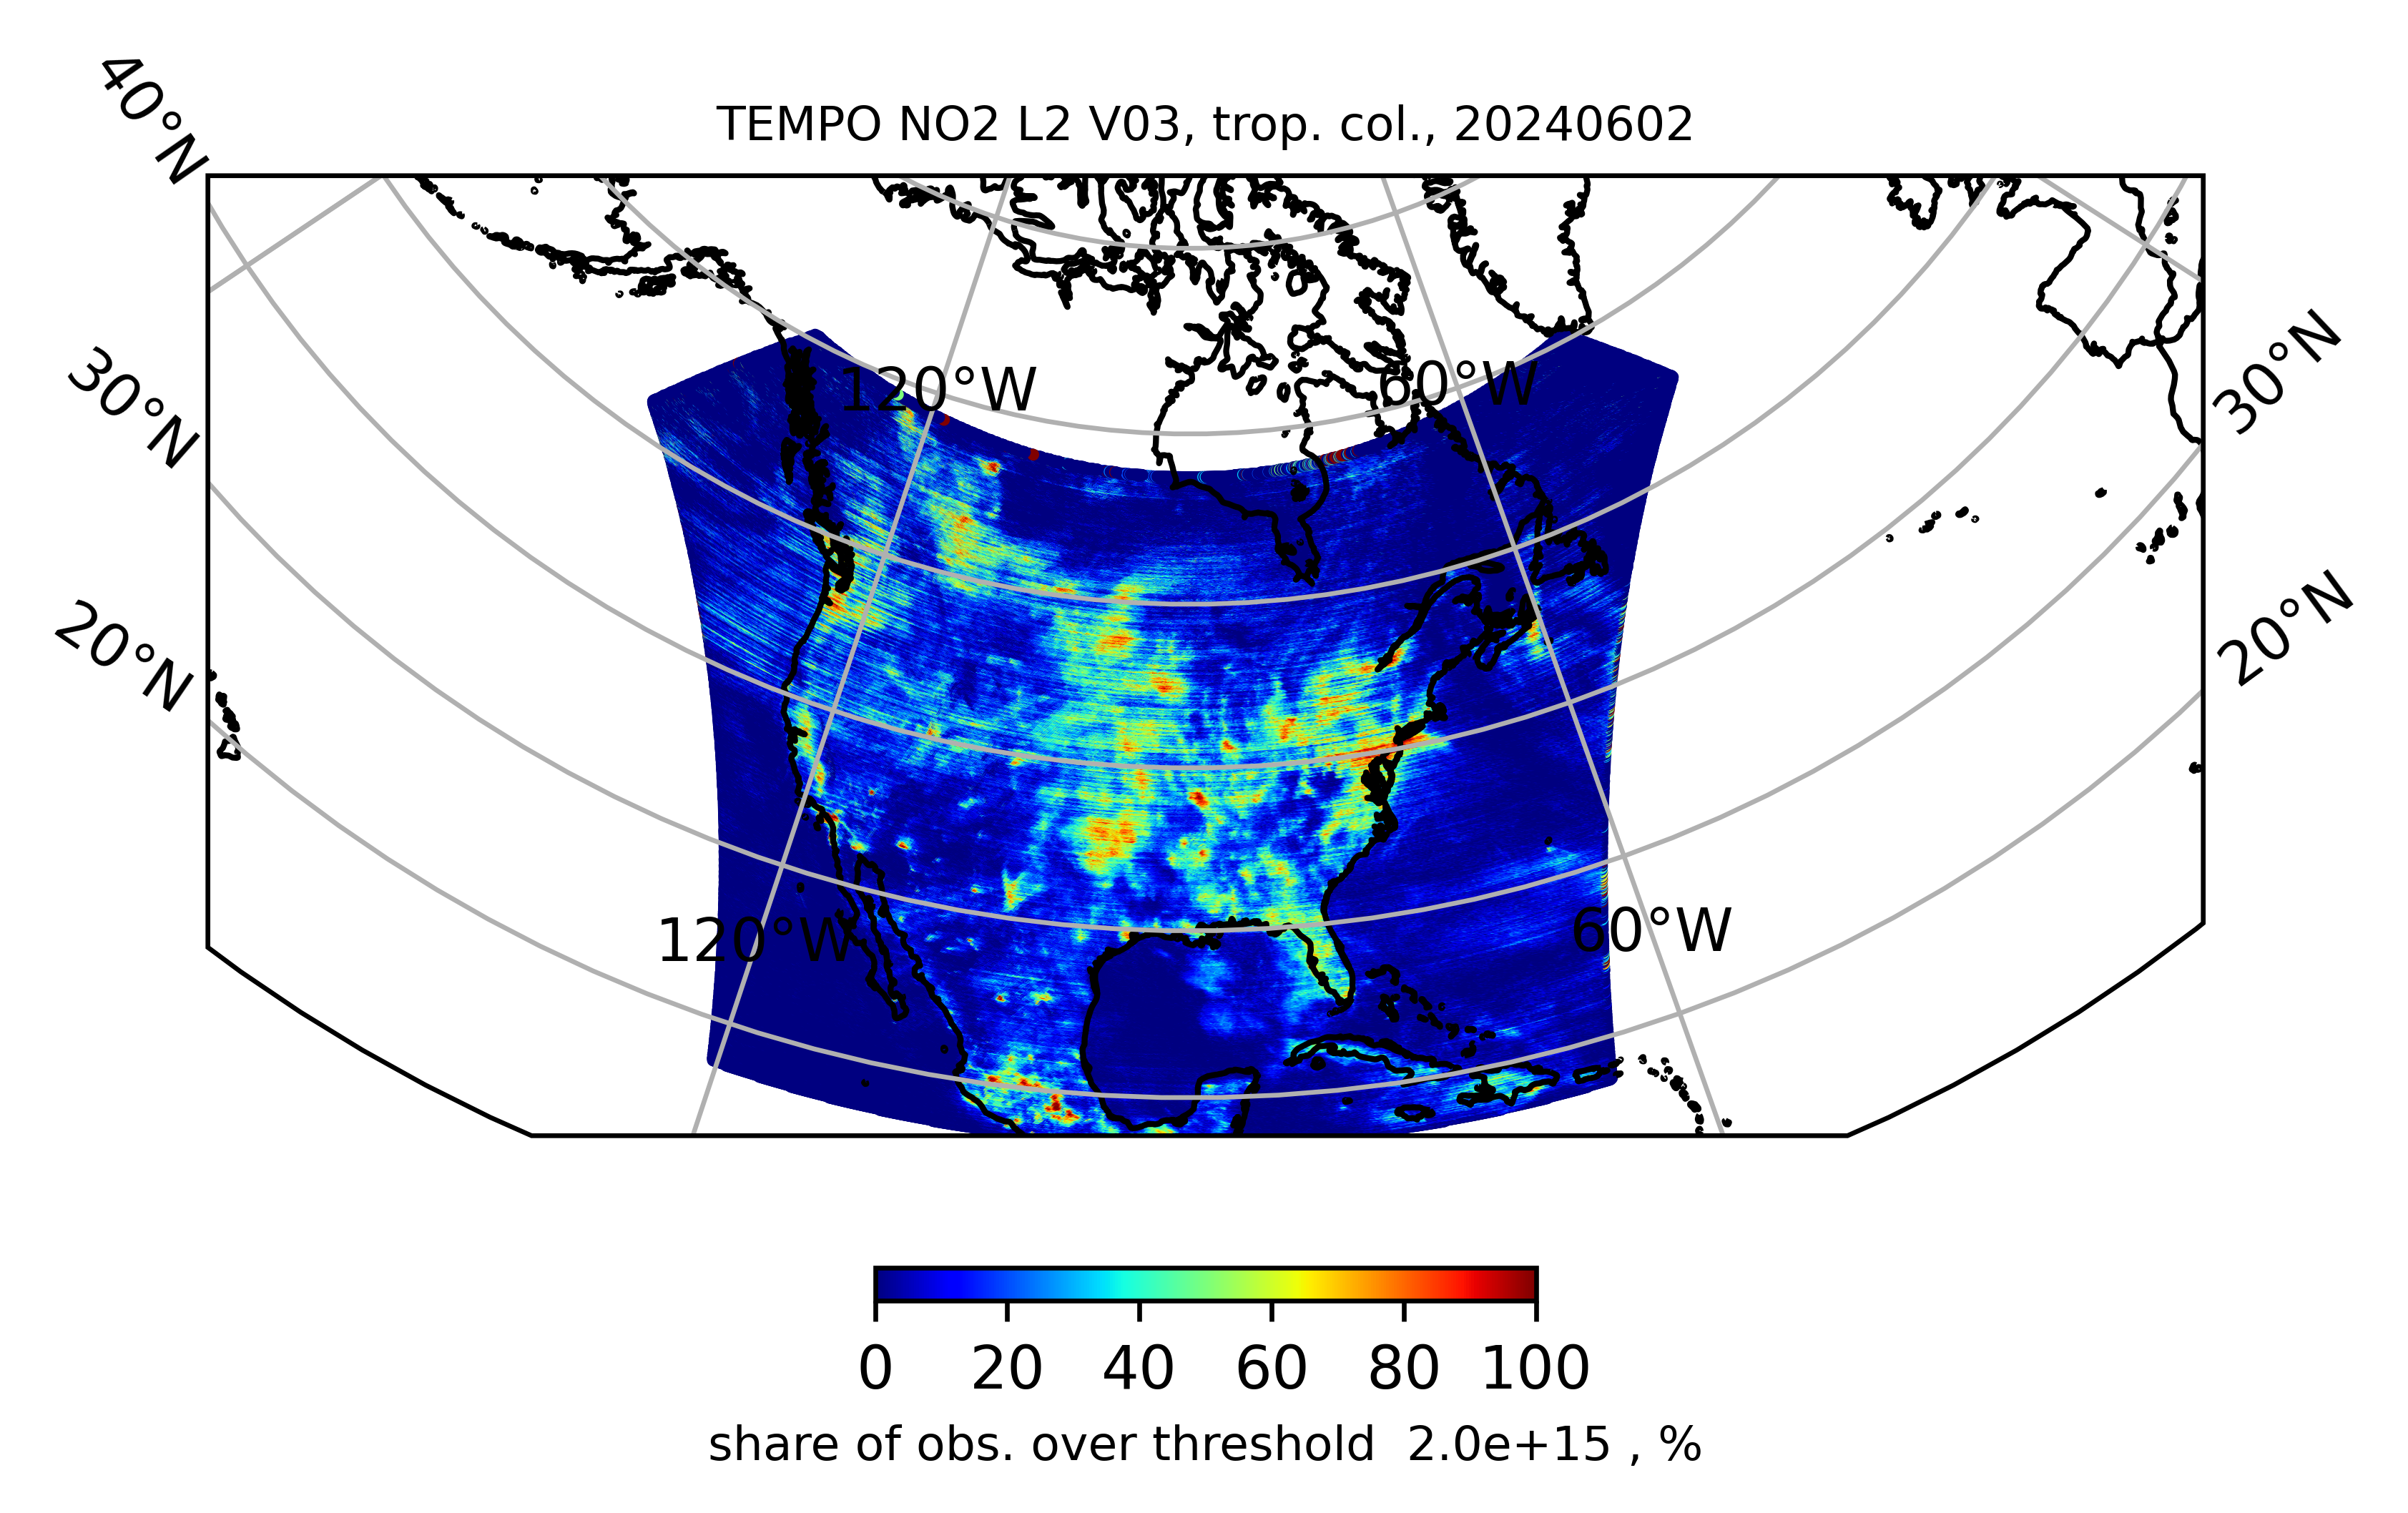

In [11]:
# plotting the ratio of number of TEMPO NO2 trop col above the threshold to the total number of valid measurements
fig = plt.figure(figsize=(6, 4), dpi=600, facecolor = None)

proj = ccrs.LambertConformal(central_longitude=-91.0
                           , central_latitude=39.0
                           , false_easting=0.0
                           , false_northing=0.0
                           , standard_parallels=(33, 45)
                           , globe=None
                           , cutoff=10)
transform=ccrs.PlateCarree()

ax1 = fig.add_subplot(111, projection=proj)
ax1.set_extent([grid_lon[0], grid_lon[-1], grid_lat[0], grid_lat[-1]], crs=transform)
im1 = ax1.scatter(valid_lon, valid_lat, c=ratio, s=1., cmap=plt.cm.jet\
                , vmin=0, vmax=100, transform=transform)
ax1.coastlines(resolution='50m', color='black', linewidth=1)
gl = ax1.gridlines(draw_labels=True, dms=True)
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
cb1 = plt.colorbar(im1, ticks=[0, 20, 40, 60, 80, 100], fraction=0.025, pad=0.1, orientation='horizontal')
cb1.set_label(f'share of obs. over threshold {thresh: 7.1e} , %', fontsize=8)
ax1.set_title('TEMPO NO2 L2 V03, trop. col., '+ datestamp, fontsize=8)

plt.savefig('TEMPO_NO2_L2_V03_trop_col_dailystat_'+ datestamp+'.png', dpi=600)
plt.show()
plt.close()

# 9 Writing output to netCDF file

In [12]:
success = write_trop_NO2_ratio_nc(grid_lat, grid_lon, ratio_2D, thresh, datestamp)